<style>
.rendered_html * + p, .rendered_html p {
    text-align:justify;
}
.print {
    display:none;
}
.highlight {
    background:white;
}
@media print {
 a[href]:after {
     content: ""
 }
 .noprint {
  display:none
  }
  .print {
        display:block;
    }
}
</style>
<head>
    <base target="_blank">
</head>
<div style="text-align:left"><a href="http://web.dmi.unict.it/"><img src="img/dmi.png" style="width:300px; margin:0;"></a></div>

<a href="http://iplab.dmi.unict.it/"><img src="img/iplab.png" style="width:900px"></a>
<center><h2>Machine Learning - A.A. 2020-2021</h2></center>
<center><h3>Regressione Logistica in Pytorch, Valutazione di Regressione e Classificazione, Regolarizzazione e Momentum</h3></center>
<br>
<center>Antonino Furnari - <a href="http://www.dmi.unict.it/~furnari/" target="_blank">http://www.dmi.unict.it/~furnari/</a> - <a href="mailto:furnari@dmi.unict.it">furnari@dmi.unict.it</a> </center>
<center>Giovanni Maria Farinella - <a href="http://www.dmi.unict.it/farinella/" target="_blank">http://www.dmi.unict.it/farinella/</a> - <a href="mailto:gfarinella@dmi.unict.it">gfarinella@dmi.unict.it</a> </center>

# 1. Valutazione di un regressore lineare

Nello scorso laboratorio abbiamo visto come allenare un regressore lineare. Vediamo ora come valutarlo. Iniziamo caricando il dataset visto nello scorso laboratorio e suddividendolo in training e testing set:

In [1]:
from sklearn.datasets import load_boston
import numpy as np
import torch
from torch import nn

np.random.seed(123)
torch.random.manual_seed(123);

boston = load_boston()
X = boston.data
Y = boston.target

idx = np.random.permutation(len(X))

X = X[idx]
Y = Y[idx]

X_training = torch.Tensor(X[50:])
Y_training = torch.Tensor(Y[50:])
X_testing = torch.Tensor(X[:50])
Y_testing = torch.Tensor(Y[:50])

Definiamo l'oggetto `LinearRegressor` come visto nello scorso laboratorio:

In [2]:
class LinearRegressor(nn.Module):
    def __init__(self, in_size, out_size):
        """Costruisce un regressore logistico.
            Input:
                in_size: numero di feature in input (es. 13)
                out_size: numero di elementi in output (es. 1)"""
        super(LinearRegressor, self).__init__() #richiamo il costruttore della superclasse
        #questo passo è necessario per abilitare alcuni meccanismi automatici dei moduli di PyTorch
        
        self.linear = nn.Linear(in_size,out_size)
        
    def forward(self,x):
        """Definisce come processare l'input x"""
        result = self.linear(x)
        
        return result

Effettuiamo l'allenamento del regressore lineare come visto nello scorso laboratorio:

In [3]:
from torch.utils.tensorboard import SummaryWriter

lr = 0.01
epochs = 300

writer = SummaryWriter('logs/linear_regressor_1')

#normalizzazione dei dati
means = X_training.mean(0)
stds = X_training.std(0)

X_training_norm = (X_training-means)/stds
X_testing_norm = (X_testing-means)/stds

reg = LinearRegressor(13,1)
criterion = nn.MSELoss()

optimizer = torch.optim.SGD(reg.parameters(),lr=lr)

for e in range(epochs):
    reg.train()
    output = reg(X_training_norm)
    l = criterion(output.view(-1),Y_training)
    
    writer.add_scalar('loss/train', l.item(), global_step=e)
    
    l.backward()
    
    optimizer.step()
    optimizer.zero_grad()

    reg.eval()
    
    with torch.set_grad_enabled(False):
        y_test = reg(X_testing_norm)
        l = criterion(y_test.view(-1),Y_testing)
        writer.add_scalar('loss/test', l.item(), global_step=e)

A questo punto possiamo utilizzare il modello per predire le etichette sia per il training che per il test set:

In [4]:
preds_training = reg(X_training_norm)
preds_testing = reg(X_testing_norm)

Un modo semplice per valutare il modello consiste nel calcolare l'errore MSE. Definiamo una funzione e utilizziamola per calcolare l'errore di test:

In [5]:
def MSE(predictions, gt):
    #inseriamo un assert per assicurarci che le due shape siano compatibili
    #questo serve ad evitare problemi indotti dal broadcasting
    assert predictions.shape == gt.shape
    return ((predictions-gt)**2).mean()

#quando chiamiamo il metodo MSE, facciamo un reshape delle predizioni in modo che da shape [N x 1] diventino di shape [1]
print("Mean Squared Error (MSE) di training: {:0.2f}".format(MSE(preds_training.view(-1),Y_training)))
print("Mean Squared Error (MSE) di testing: {:0.2f}".format(MSE(preds_testing.view(-1),Y_testing)))

Mean Squared Error (MSE) di training: 20.52
Mean Squared Error (MSE) di testing: 44.04


L'unità di misura dell'errore MSE è la stessa unità dei dati al quadrato. Pertanto, dato che i target del dataset considerato si misurano in migliaia di dollari, l'errore riportato è in migliaia di dollari al quadrato. Se vogliamo avere un errore nella stessa unità di misura dei dati in ingresso, possiamo definire il Root Mean Squared Error (RMSE), ottenuto prendendo la radice quadrata di MSE:

In [6]:
def RMSE(predictions, gt):
    assert predictions.shape == gt.shape
    return ((predictions-gt)**2).mean()**(1/2)

print("Root Mean Squared Error (RMSE) di training: {:0.2f}".format(RMSE(preds_training.view(-1),Y_training)))
print("Root Mean Squared Error (RMSE) di testing: {:0.2f}".format(RMSE(preds_testing.view(-1),Y_testing)))

Root Mean Squared Error (RMSE) di training: 4.53
Root Mean Squared Error (RMSE) di testing: 6.64


Gli errori adesso ci dicono quanto il modello sbaglia in media in "migliaia di errori".

Un ulteriore misura di errore generalmente utilizzata è il Mean Absolute Error (MAE), che consiste nel calcolare la media dei valori assoluti delle differenze tra valori predetti e valori di ground truth. Anche in questo caso l'unità di misura è la stessa dei valori di target. Implementiamo la misura di errore e calcoliamo errore su trainin e test set:

In [7]:
def MAE(predictions, gt):
    assert predictions.shape == gt.shape
    return ((predictions-gt).abs()).mean()

print("Mean Absolute Error (MAE) di training: {:0.2f}".format(MAE(preds_training.view(-1),Y_training)))
print("Mean Absolute Error (MAE) di testing: {:0.2f}".format(MAE(preds_testing.view(-1),Y_testing)))

Mean Absolute Error (MAE) di training: 3.08
Mean Absolute Error (MAE) di testing: 4.31


Un altro modo per valuatare un regressore, consiste nel costruire una curva REC (Regression Error Curve). La curva riporta sull'asse delle $x$ una serie di soglie di tolleranza e sull'asse delle $y$ la percentuale degli elementi di test che presentano un errore inferiore o uguale alla soglia corrispondente. Inoltre, alla curva è spesso associata l'area sopra la curva (AOC) per offrire una misura dell'errore del metodo. Definiamo una funzione che calcoli tali valori:

In [8]:
from matplotlib import pyplot as plt
def rec_curve(predictions, gt):
    assert predictions.shape == gt.shape
    #calcoliamo tutti gli errori mediante MAE
    errors = np.abs(np.array((predictions.detach()-gt)))
    #prendiamo i valori unici degli erorri e ordiniamoli
    tolerances = sorted(np.unique(errors))
    correct= [] #lista delle "accuracy" relative a ogni soglia
    for t in tolerances:
        correct.append((errors<=t).mean()) #frazione di elementi "correttamente" regressi
    AUC = np.trapz(correct, tolerances) #area sotto la curva calcolata col metodo dei trapezi
    tot_area = np.max(tolerances)*1 #area totale
    AOC = tot_area - AUC
    #restituiamo le soglie, la frazione di campioni correttamente regressi e l'area sopra la curva
    return tolerances, correct, AOC

Utilizziamo la funzione per calcolare la curva REC e plottiamola:

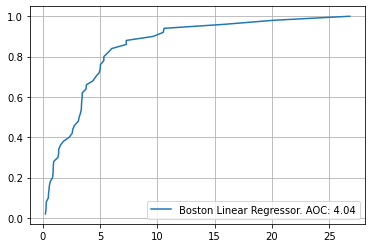

In [9]:
boston_linear_regressor_rec = rec_curve(preds_testing.view(-1),Y_testing)
plt.plot(boston_linear_regressor_rec[0], boston_linear_regressor_rec[1])
plt.legend(['Boston Linear Regressor. AOC: %0.2f'%boston_linear_regressor_rec[2]])
plt.grid()
plt.show()

In pratica, le curve REC possono essere molto utili per confrontare le performance di due regressori diversi. Confrontiamo ad esempio le performance del regressore su training e test set:

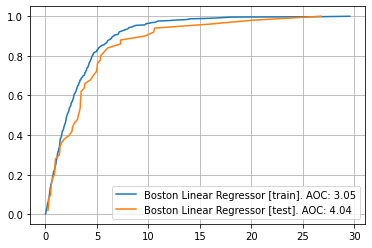

In [10]:
boston_linear_regressor_training_rec = rec_curve(preds_training.view(-1),Y_training)
boston_linear_regressor_testing_rec = rec_curve(preds_testing.view(-1),Y_testing)
plt.plot(boston_linear_regressor_training_rec[0], boston_linear_regressor_training_rec[1])
plt.plot(boston_linear_regressor_testing_rec[0], boston_linear_regressor_testing_rec[1])
plt.legend(['Boston Linear Regressor [train]. AOC: %0.2f'%boston_linear_regressor_training_rec[2],'Boston Linear Regressor [test]. AOC: %0.2f'%boston_linear_regressor_testing_rec[2]])
plt.grid()
plt.show()

# 2. Regressione Logistica in PyTorch

Abbiamo visto come allenare un regressore lineare utilizzando PyTorch. Vediamo adesso come implementare e allenare un regressore logistico. Consideriamo il dataset "Breast Cancer" contenuto in **scikit-learn**:

In [11]:
from sklearn.datasets import load_breast_cancer
dataset = load_breast_cancer()
X=dataset.data
Y=dataset.target
#features
print(X.shape)
#classi target
print(Y.shape)
print(Y[:100])

(569, 30)
(569,)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 1 0 1 1 1 1 1 0 0 1 0 0 1 1 1 1 0 1 0 0 1 1 1 1 0 1 0 0
 1 0 1 0 0 1 1 1 0 0 1 0 0 0 1 1 1 0 1 1 0 0 1 1 1 0]


Il dataset contiene 569 osservazioni. Ognuna di esse contiene $30$ attributi relativi a misurazioni di alcune proprietà dei nuclei delle cellule di un tessuto sotto analisi. Ogni osservazione può appartenere alla classe $1$ (cancro presente) o alla classe $0$ (cancro assente). Si veda https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Diagnostic) per maggiori informazioni.

Analogamente a quanto fatto nel caso del regressore lineare, vorremmo poter costruire un algoritmo che, dato un nuovo campione contenente le $30$ osservazioni, lo classifichi come appartenente alla classe $0$ o alla classe $1$.

Potremmo pensare di allenare un classificatore lineare per predire i valori $0$ o $1$ dai dati, tuttavia avremmo un problema: _anche se alleniamo il regressore usando solo valori target pari a $0$ o $1$, una volta allenato, il regressore sarebbe in grado di predire anche valori diversi da $0$ o $1$_. In generale, ciò renderebbe poco chiaro come interpretare i valori predetti dal regressore.


Per poter trattare comunque il probelma con un problema di regressione, potremmo pensare di predire la **probabilità che la classe target sia pari a $1$**. Le probabilità sono dei valori continui, che quindi risolverebbero in parte il problema discusso sopra. Tuttavia, le probabilità restano dei numeri compresi tra $0$ e $1$, mentre il regressore potrebbe predire valori arbitrari (es, $100$). 

Dobbiamo dunque effettuare una trasformazione dei valori di probabilità che restituisca valori continui e non compresi tra $0$ e $1$. Una trasformazione possibile si ottiene utilizzando la funzione **logit**:

\begin{equation}
logit(P) = ln(\frac{P(1\ |\ \mathbf{x})}{1-P(1\ |\ \mathbf{x})})
\end{equation}

dove $P(1\ |\ \mathbf{x})$ è la probabilità che la classe relativa al campione $\mathbf{x}$ sia $1$ e, di conseguenza, $1-P(1\ |\ \mathbf{x})=P(0\ |\ \mathbf{x})$ indica la probabilità che la classe corretta sia $0$. L'espressione $\frac{P(1\ |\ \mathbf{x})}{1-P(1\ |\ \mathbf{x})}$ è detta "odd" e assume sempre valori positivi e che tali valori possono essere sia minori di $1$ (se $P(1|\mathbf{x})<0.5$), che maggiori di $1$ (se $P(1|\mathbf{x})>0.5$), pertanto il dominio della funzione logit è l'insieme dei numeri reali. Un regressore lineare si presta dunque bene a predire questo genere di valori. Definiamo il nostro problema quindi come un problema di regressione lineare in cui vogliamo predire da ogni campione uno "score" $z$ che poniamo uguale al logit:

\begin{equation}
z = logit(P) = ln(\frac{P(1\ |\ \mathbf{x})}{1-P(1\ |\ \mathbf{x})})
\end{equation}

Il regressore sarà dunque definito come segue:

\begin{equation}
z = \theta_0 + \theta_1 x_1 + \ldots + \theta_n x_n
\end{equation}

Dove $\mathbf{x}=x_1,\ldots,x_n$ è il vettore in ingresso e $\theta_0, \ldots, \theta_n$ sono i parametri del regressore logistico.

Una volta allenato il regressore, lo si può utilizzare per predire i valori $z=logit(\hat P(1|\mathbf{x})$. Dunque si può ottenere la probabilità $P(1|\mathbf{x})$ utilizzando la funzione inversa della funzione logit, nota anche come **funzione logistica**:

\begin{equation}
\hat P(1|\mathbf{x}) = p = \frac{1}{1+e^{-z}}
\end{equation}

dove $\hat P(1|\mathbf{x})$ è la probabilità stimata che la classe del campione $\mathbf{x}$ sia $1$. Inoltre si ha:

\begin{equation}
\hat P(0|\mathbf{x}) = 1-p=1-\frac{1}{1+e^{-z}}=\frac{1}{1+e^{z}}
\end{equation}

Per allenare il regressore logistico, definiamo una funzione di "loss" che assume valori alti quando le nostre predizioni sono sbagliate e valori bassi quando le predizioni sono corrette. La funzione di loss per un dato campione $\mathbf{x}$ è definita come segue:

\begin{equation}
\mathcal{L}_\theta(z,y) = -y log(p) - (1-y) log(1-p)
\end{equation}

o alternativamente, in funzione di $z$:

\begin{equation}
\mathcal{L}_\theta(z,y) = -y log(\frac{1}{1+e^{-z}}) - (1-y) log(\frac{1}{1+e^{z}})
\end{equation}

Date le proprietà dei logaritmi, la funzione sopra si può scrivere come:

\begin{equation}
\mathcal{L}_\theta(z,y) = y log(1+e^{-z}) + (1-y) log(1+e^{z})
\end{equation}


dove $z$ è lo score stimato, $y$ rappresenta la classe corretta e $L$ è una funzione differenziabile rispetto ai parametri $\beta_i$. In generale, la loss viene definita su un insieme di $N$ campioni $\mathbf{x}_i$:

\begin{equation}
\mathcal{L}_\theta(z,y) = \frac{1}{N}\sum_i-y_i log(p_i) - (1-y_i) log(1-p_i)=\frac{1}{N}\sum_i y_i log(1+e^{-z_i}) + (1-y_i) log(1+e^{z_i})
\end{equation}

In pratica, un **regressore logistico** si può vedere come un **regressore lineare** al quale output è stata applicata la **funzione logistica**. Vediamo come implementarlo. Impostiamo un seed per avere risultati ripetibili:

In [12]:
import torch
import numpy as np
np.random.seed(1234)
torch.random.manual_seed(1234);

Otteniamo una permutazione casuale dei dati:

In [13]:
idx = np.random.permutation(len(X))

Applichiamo la stessa permutazione a X e Y:

In [14]:
X = X[idx]
Y = Y[idx]

Suddividiamo il dataset in **training** e **testing** set indipendenti selezionando i primi $100$ valori per formare il testing set. Trasformiamo inoltre gli array in tensori. In questo caso non dobbiamo specificare `require_grads=True` in quanto si tratta di osservazioni che non andremo a ottimizzare:

In [15]:
X_training = torch.Tensor(X[100:])
Y_training = torch.Tensor(Y[100:])
X_testing = torch.Tensor(X[:100])
Y_testing = torch.Tensor(Y[:100])

Normalizziamo i dati per media e deviazione standard:

In [16]:
X_mean = X_training.mean(0)
X_std = X_training.std(0)
X_training_norm = (X_training-X_mean)/X_std
X_testing_norm = (X_testing-X_mean)/X_std

Definiamo dunque un normale regressore della forma seguente per iniziare:


\begin{equation}
y(x) = \theta_0 + \theta_1 x_1 + \ldots + \theta_{30} x_{30}
\end{equation}

Il modello dipenderà da $31$ parametri. $30$ sono relativi alle $30$ feature in ingresso, mentre il trentunesimo rappresenta l'intercetta della retta di regressione. Possiamo costruire il regressore lineare usando `nn.Linear`:

In [17]:
from torch import nn
linear_regressor = nn.Linear(30,1)

Proviamo ad applicare la funzione ai nostri dati:

In [18]:
z = linear_regressor(X_training_norm)
print(z[:10]) #stampiamo i primi 10 valori predetti

tensor([[-0.1096],
        [ 0.0380],
        [ 0.2178],
        [ 0.3410],
        [ 0.1903],
        [ 0.4142],
        [-0.0980],
        [-0.0238],
        [ 0.1587],
        [ 0.1500]], grad_fn=<SliceBackward>)


Questi valori rappresentano i nostri score $z$, ovvero i **logit**. Verifichiamo che il range dei score non è compatibile con la definizione di probabilità:

In [19]:
print(z.min())
print(z.max())

tensor(-0.9687, grad_fn=<MinBackward1>)
tensor(1.2384, grad_fn=<MaxBackward1>)


Per ottenere delle probabilità, dobbiamo applicare la funzione logistica. Definiamola:

In [20]:
def logistic(z):
    return 1./(1+torch.exp(-z))

Applichiamo la funzione ai dati:

In [21]:
p = logistic(z)
print(p[:10])

tensor([[0.4726],
        [0.5095],
        [0.5542],
        [0.5844],
        [0.5474],
        [0.6021],
        [0.4755],
        [0.4941],
        [0.5396],
        [0.5374]], grad_fn=<SliceBackward>)


Possiamo verificare che i valori ottenuti siano delle probabilità valide, ovvero che siano compresi tra $0$ e $1$:

In [22]:
print(p.min())
print(p.max())

tensor(0.2751, grad_fn=<MinBackward1>)
tensor(0.7753, grad_fn=<MaxBackward1>)


Pytorch mette a disposizione una implementazione della funzione logistica mediante l'oggetto `nn.Sigmoid` (la funzione logistica è detta anche sigmoide):

In [23]:
sigmoid=nn.Sigmoid()

La funzione ha lo stesso comportamento di quella definita da noi:

In [24]:
p2=sigmoid(z)
print(p2.min())
print(p2.max())

tensor(0.2751, grad_fn=<MinBackward1>)
tensor(0.7753, grad_fn=<MaxBackward1>)


Definiamo adesso la funzione di loss a partire dai valori di probabilità:

In [25]:
def loss(p,y):
    return (-y*torch.log(p)-(1-y)*torch.log(1-p)).mean()

Calcoliamo la loss per le predizioni appena ottenute:

In [26]:
print(loss(p,Y_training.view(-1,1)))

tensor(0.6579, grad_fn=<MeanBackward0>)


La stessa funzione di loss è implementata mediante il modulo `BCELoss` (Binary Cross Entropy Loss):

In [27]:
loss = nn.BCELoss()

Verifichiamo che la loss funzioni esattamente come quella da noi implementata:

In [28]:
print(loss(p,Y_training.view(-1,1)))

tensor(0.6579, grad_fn=<BinaryCrossEntropyBackward>)


Adesso abbiamo tutti gli ingredienti che ci servono per allenare il regressore logistico. Effettuiamo il training utilizzando lo schema visto nel caso della regressione lineare:

 1. Normalizzare i dati in ingresso $\mathbf{x}$; 
 2. Inizializzare i parametri $\theta$ in maniera opportuna;
 3. Calcolare i logit $\hat{\mathbf{z}} = \sum_i (\theta_i x_i) + \theta_0$;
 4. Calcolare le probabilità $p=\frac{1}{1+e^{-z}}$;
 5. Calcolare il valore della loss $\mathcal{L}_{\theta}(p,y)$;
 6. Calcolare il gradiente rispetto ai parametri $\theta$ della funzione di loss $\nabla_\theta \mathcal{L}_\theta(p,y)$;
 7. Aggiornare i pesi $\theta$ secondo la regola: $\theta = \theta - \eta \nabla_\theta \mathcal{L}_\theta(p,y)$, dove $\eta$ è il learning rate;
 8. Ripetere i passi 3-7 fino a convergenza.

**Domanda 1**
<img src="img/qmark.jpg" style="width:150px; float:left;"/>

Quali sono le differenze tra questa procedura di training e quella vista nel caso del regressore lineare?

**Risposta 1**
<img style="float: left;width:150px;" src="img/note.png">

<div style="background-color:#efefef; margin-left:150px; border:solid 1px; border-color:#dddddd; border-radius: 3px;">
<br><br><br><br><br><br>
</div>

Prima di passare all'implementazione, definiamo un oggetto che effettui la regressione lineare:

In [29]:
class LogisticRegressor(nn.Module):
    def __init__(self, in_features):
        """Costruisce un regressore logistico.
            Input:
                in_features: numero di feature in input (es. 30)"""
        super(LogisticRegressor, self).__init__() #richiamo il costruttore della superclasse
        #questo passo è necessario per abilitare alcuni meccanismi automatici dei moduli di PyTorch
        
        self.linear = nn.Linear(in_features,1) #il regressore logistico restituisce probabilità
        #quindi il numero di feature di output è "1"
        self.logistic = nn.Sigmoid()
        
    def forward(self,x):
        """Definisce come processare l'input x"""
        logits = self.linear(x)

        return self.logistic(logits)

Implmentiamo adesso la procedura di training impostando il learning rate a $0.1$ e ottimizzando il modello per $500$ epoche. Utilizzeremo tensorboard per tracciare la procedura di training:

In [30]:
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter('logs/logistic_regressor')

lr = 0.01
epochs = 500

# Passo 1: normalizzazione dei dati
means = X_training.mean(0)
stds = X_training.std(0)

X_training_norm = (X_training-means)/stds
X_testing_norm = (X_testing-means)/stds

#Passo 2: inizializziamo il modello
regressor = LogisticRegressor(30)

loss = nn.BCELoss()
sgd = torch.optim.SGD(regressor.parameters(), lr)

for e in range(epochs):
    regressor.train()
    #Passo 3 & 4: calcoliamo le probabilità
    p = regressor(X_training_norm)
    
    #Passo 5: calcoliamo il valore della loss
    l = loss(p, Y_training.view(-1,1))
    
    #Passo 6: calcoliamo il gradiente della loss rispetto a tutti i parametri
    l.backward()
    
    #facciamo log del valore della loss
    writer.add_scalar('loss/train', l.item(), global_step=e)
    
    #Passo 7: Aggiorniamo i pesi
    sgd.step()
    
    #azzeriamo i gradienti per evitare di accumularli
    sgd.zero_grad()
    
    #calcoliamo e facciamo log la loss di test:
    regressor.eval()
    with torch.set_grad_enabled(False):
        p = regressor(X_testing_norm)
        l = loss(p, Y_testing.view(-1,1))
        writer.add_scalar('loss/test', l.item(), global_step=e)

**Domanda 2**
<img src="img/qmark.jpg" style="width:150px; float:left;"/>

Si evidenzino le differenze tra il codice mostrato sopra e quello visto nel caso del regressore lineare.

**Risposta 2**
<img style="float: left;width:150px;" src="img/note.png">

<div style="background-color:#efefef; margin-left:150px; border:solid 1px; border-color:#dddddd; border-radius: 3px;">
<br><br><br><br><br><br>
</div>

Su tensorboard si dovrebbe visualizzare un grafico del genere:

<img width=75% src='img/graph1_tf.jpg'>

**Domanda 3**
<img src="img/qmark.jpg" style="width:150px; float:left;"/>

Si osservi il grafico ottenuto. Possiamo dire che il modello è arrivato a convergenza? Avrebbe senso allenarlo per un numero minore di epoche? E per un numero maggiore?

**Risposta 3**
<img style="float: left;width:150px;" src="img/note.png">

<div style="background-color:#efefef; margin-left:150px; border:solid 1px; border-color:#dddddd; border-radius: 3px;">
<br><br><br><br><br><br>
</div>

Adesso otteniamo le predizioni per il test set utilizzando il modello finale e calcoliamo la relativa loss:

In [31]:
#iniziamo calcolando le predizioni del modello dati i pesi allenati
p_test = regressor(X_testing_norm)
#calcoliamo il valore della loss
print(loss(p_test, Y_testing.view(-1,1)))

tensor(0.1860, grad_fn=<BinaryCrossEntropyBackward>)


L'output del regressore logistico consiste in probabilità. Per ottenere le etichette ("0" o "1"), sogliamo le probabilità. Tutti gli elementi per i quali abbiamo predetto probabilità maggiore o uguale a $0.5$ saranno di classe $1$, mentre gli altri saranno di classe $0$:

In [32]:
prob_training = regressor(X_training_norm)
prob_testing = regressor(X_testing_norm)

pred_training = prob_training>=0.5
pred_testing = prob_testing>=0.5

print(pred_testing[:10])

tensor([[ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [False],
        [False]])


Adesso abbiamo le etichette predette dal modello. Per capire "quanto" il modello funziona, possiamo confrontare queste predizioni con i valori di ground truth. Iniziamo con una semplice misura di valutazione, l'accuracy, che conta la frazione di elementi per i quali è stata predetta la corretta etichetta:

In [33]:
def accuracy(pred,gt):
    """Calcola l'accuracy date le predizioni pred
    e le etichette di ground truth gt"""
    correct = pred.view(-1).byte()==gt.view(-1).byte() 
    #conterrà true in corrispondenza degli elementi per i quali è stata predetta la classe corretta
    #inseriamo "view(-1)" per essere sicuri di lavorare con array monodimensionali
    return float(correct.sum())/len(correct)#conta il numero di predizioni corrette e divide per il numero totale di predizioni

**Domanda 3**
<img src="img/qmark.jpg" style="width:150px; float:left;"/>

Si discuta la funzione `accuracy`. Perché richiamiamo il metodo `.byte` sui due tensori? 

**Risposta 3**
<img style="float: left;width:150px;" src="img/note.png">

<div style="background-color:#efefef; margin-left:150px; border:solid 1px; border-color:#dddddd; border-radius: 3px;">
<br><br><br><br><br><br>
</div>

Calcoliamo dunque le accuracy di training e di test:

In [34]:
print("Accuracy di training: {:0.2f}".format(accuracy(pred_training,Y_training)))
print("Accuracy di test: {:0.2f}".format(accuracy(pred_testing,Y_testing)))

Accuracy di training: 0.97
Accuracy di test: 0.93


**Domanda 4**
<img src="img/qmark.jpg" style="width:150px; float:left;"/>

Perché il classificatore funziona meglio sul training set che sul test set?

**Risposta 4**
<img style="float: left;width:150px;" src="img/note.png">

<div style="background-color:#efefef; margin-left:150px; border:solid 1px; border-color:#dddddd; border-radius: 3px;">
<br><br><br><br><br><br>
</div>

L'accuracy è una misura di performance molto intuitiva per un classificatore. Un valore prossimo a $1$ indica che tutti gli elementi sono stati classificati correttamente, mentre un valore prossimo a zero indica che nessun elemento è stato classificato correttamente.

**Domanda 5**
<img src="img/qmark.jpg" style="width:150px; float:left;"/>

Un classificatore ottiene una accuracy pari a $0.91$ su un dataset di $189$ elementi. Quanti elementi sono stati classificati correttamente? Quanti elementi non sono stati classificati correttamente?

**Risposta 5**
<img style="float: left;width:150px;" src="img/note.png">

<div style="background-color:#efefef; margin-left:150px; border:solid 1px; border-color:#dddddd; border-radius: 3px;">
<br><br><br><br><br><br>
</div>

E' spesso utile monitorare come l'accuracy di training e test cambiano durante l'allenamento di un modello, in maniera analoga a quanto visto nel caso della loss. Modifichiamo il codice di training visto prima per plottare anche accuracy di training e test mediante tensorboard:

In [35]:
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter('logs/logistic_regressor_2')

lr = 0.01
epochs = 500

means = X_training.mean(0)
stds = X_training.std(0)

X_training_norm = (X_training-means)/stds
X_testing_norm = (X_testing-means)/stds

regressor = LogisticRegressor(30)

loss = nn.BCELoss()
sgd = torch.optim.SGD(regressor.parameters(), lr)

for e in range(epochs):
    regressor.train()
    p = regressor(X_training_norm)    
    l = loss(p, Y_training.view(-1,1))
    l.backward()
    writer.add_scalar('loss/train',l.item(),global_step=e)
    sgd.step()
    sgd.zero_grad()

    writer.add_scalar('accuracy/train',accuracy(p>=0.5,Y_training),global_step=e)
    
    regressor.eval()
    with torch.set_grad_enabled(False):
        p = regressor(X_testing_norm)
        l = loss(p, Y_testing.view(-1,1))
        writer.add_scalar('loss/test',l.item(),global_step=e)
        
        #calcoliamo e facciamo log dell'accuracy di training a partire dalle predizioni
        writer.add_scalar('accuracy/test',accuracy(p>=0.5,Y_testing),global_step=e)

In tensorboard si dovrebbe a questo punto visualizzare un grafico del genere:

<img width=75% src='img/graph2_tf.jpg'>

**Domanda 6**
<img src="img/qmark.jpg" style="width:150px; float:left;"/>

Accuracy e loss sono concordi? A cosa è dovuta la discretizzazione della curva di accuracy? Perché quella di loss non è altrettanto discretizzata?

**Risposta 6**
<img style="float: left;width:150px;" src="img/note.png">

<div style="background-color:#efefef; margin-left:150px; border:solid 1px; border-color:#dddddd; border-radius: 3px;">
<br><br><br><br><br><br>
</div>

## 2.1 Stabilità Numerica
Finora abbiamo utilizzato la loss:

\begin{equation}
\mathcal{L}_\theta(z,y) = \frac{1}{N}\sum_i-y_i log(p_i) - (1-y_i) log(1-p_i)
\end{equation}

dove:
\begin{equation}
p_i = \frac{1}{1+e^{-z_i}}
\end{equation}

Questa loss può essere numericamente instabile in quanto, per valori di $z_i$ molto bassi, $e^{-z_i}$ sarà un numero molto alto e di conseguenza $p_i$ sarà molto piccolo. Se il valore di $p_i$ scende al di sotto della precisione della macchina (cioè va in underflow), esso verrà arrotondato a zero. A questo punto, all'interno della funzione di loss $\mathcal{L}$, il valore $y_i\log(p_i)$ restituirà un `nan` se $y_i=0$.

Per evitare questi problemi, in genere si utilizza la loss definita a partire dai logit:

\begin{equation}
\mathcal{L}_\theta(z,y) =\frac{1}{N}\sum_i y_i log(1+e^{-z_i}) + (1-y_i) log(1+e^{z_i})
\end{equation}

Notiamo che questa loss non soffre dei problemi discussi sopra. Per valori molto bassi di $z_i$, infatti $e^{-z_i}$ non comparirà, mentre il termine $1+e^{-z_i}$ sarà almeno pari a $1$ (per cui potremo sempre calcolarne il logaritmo. Possiamo dunque effettuare la procedura di training evitando di calcolare esplicitamente le probabilità e applicando la seconda loss direttamente ai logit $z_i$. Definiamo la loss:

In [36]:
def loss2(z,y):
    return (y*torch.log(1+torch.exp(-z))+(1-y)*torch.log(1+torch.exp(z))).mean()

La loss vista sopra va applicata direttamente ai logit, mentre il nostro modello restituisce direttamente probabilità. Modifichiamo il modello per restituire i logit invece delle probabilità:

In [37]:
class LogisticRegressor(nn.Module):
    def __init__(self, in_features):
        super(LogisticRegressor, self).__init__() 
        self.linear = nn.Linear(in_features,1) 
        
    def forward(self,x):
        logits = self.linear(x)
        return logits

Se vogliamo ottenere delle probabilità in fase di test, dobbiamo trasformarle manualmente mediante la funziona logistica:

In [38]:
regressor=LogisticRegressor(30)
logistic = nn.Sigmoid()

#logits
z = regressor(X_training_norm)
print(z.min(),z.max())

#probabilità
p = logistic(z)
print(p.min(),p.max())

tensor(-2.5596, grad_fn=<MinBackward1>) tensor(1.4102, grad_fn=<MaxBackward1>)
tensor(0.0718, grad_fn=<MinBackward1>) tensor(0.8038, grad_fn=<MaxBackward1>)


In pratica, la loss definita in precedenza come `loss2` viene implementata da Pytorch mediante il modulo `nn.BCEWithLogitsLoss`. Verifichiamo che le due loss restituiscano gli stessi risultati:

In [39]:
loss_stable = nn.BCEWithLogitsLoss()
l_1=loss_stable(z,Y_training.view(-1,1))
l_2=loss2(z,Y_training.view(-1,1))
print(l_1)
print(l_2)

tensor(0.8208, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.8208, grad_fn=<MeanBackward0>)


La procedura di training diventa dunque la seguente:

1. Normalizzare i dati in ingresso $\mathbf{x}$; 
2. Inizializzare i parametri $\theta$ in maniera opportuna;
3. Calcolare i logit $\hat{\mathbf{z}} = \sum_i (\theta_i x_i) + \theta_0$;
4. Calcolare il valore della loss $\mathcal{L}_{\theta}(z,y)$;
5. Calcolare il gradiente rispetto ai parametri $\theta$ della funzione di loss $\nabla_\theta \mathcal{L}_\theta(z,y)$;
6. Aggiornare i pesi $\theta$ secondo la regola: $\theta = \theta - \eta \nabla_\theta \mathcal{L}_\theta(z,y)$, dove $\eta$ è il learning rate;
7. Ripetere i passi 3-6 fino a convergenza.

Modifichiamo il codice precedente per effettuare il training utilizzando la nuova loss:

In [40]:
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter('logs/logistic_regressor_3')

lr = 0.01
epochs = 500

means = X_training.mean(0)
stds = X_training.std(0)

X_training_norm = (X_training-means)/stds
X_testing_norm = (X_testing-means)/stds

regressor = LogisticRegressor(30)

#inseriamo qui la nuova loss
loss = nn.BCEWithLogitsLoss()
sgd = torch.optim.SGD(regressor.parameters(), lr)

for e in range(epochs):
    regressor.train()
    z = regressor(X_training_norm)    
    l = loss(z, Y_training.view(-1,1))
    l.backward()
    writer.add_scalar('loss/train',l.item(),global_step=e)
    sgd.step()
    sgd.zero_grad()
    
    #calcoliamo le probabilità
    p=logistic(z)
    writer.add_scalar('accuracy/train',accuracy(p>=0.5,Y_training),global_step=e)
    
    regressor.eval()
    with torch.set_grad_enabled(False):
        z = regressor(X_testing_norm)
        l = loss(z, Y_testing.view(-1,1))
        writer.add_scalar('loss/test',l.item(),global_step=e)
        
        #calcoliamo le probabilità
        p=logistic(z)
        writer.add_scalar('accuracy/test',accuracy(p>=0.5,Y_testing),global_step=e)

In tensorboard si dovrebbe a questo punto visualizzare un grafico del genere:

<img width=75% src='img/graph3_tf.jpg'>

Calcoliamo accuracy di training e di testing:

In [41]:
print("Accuracy di training: {:0.2f}".format(accuracy(logistic(regressor(X_training_norm))>=0.5,Y_training)))
print("Accuracy di test: {:0.2f}".format(accuracy(logistic(regressor(X_testing_norm))>=0.5,Y_testing)))

Accuracy di training: 0.97
Accuracy di test: 0.93


## 2.2 Valutazione del regressore logistico

La libreria **scikit-learn** mette a disposizione diverse misure di valutazione, tra cui l'accuracy, che finora abbiamo implementato manualmente. Prima di vedere qualche esempio, otteniamo le predizioni di training e testing:

In [42]:
preds_training = logistic(regressor(X_training_norm))>=0.5
preds_testing = logistic(regressor(X_testing_norm))>=0.5

### 2.2.1 Accuracy
Possiamo calcolare l'accuracy del classificatore mediante la funzione `accuracy_score` utilizzando la funzione messa a disposizione da scikit-learn:

In [43]:
from sklearn.metrics import accuracy_score
acc_training = accuracy_score(Y_training,preds_training)
acc_testing = accuracy_score(Y_testing,preds_testing)

print("Accuracy di training: {:0.2f}".format(acc_training))
print("Accuracy di test: {:0.2f}".format(acc_testing))

Accuracy di training: 0.97
Accuracy di test: 0.93


### 2.2.2 Matrice di Confusione

Scikit-Learn mette a disposizione anche altre misure di valutazione. Vediamo ad esempio la matrice di confusione:

In [44]:
from sklearn.metrics import confusion_matrix
cm_training =  confusion_matrix(Y_training,preds_training)
cm_testing =  confusion_matrix(Y_testing,preds_testing)
print(cm_training)
print(cm_testing)

[[169   6]
 [  6 288]]
[[32  5]
 [ 2 61]]


L'elemento di indici $i,j$ indica il numero di elementi appartenenti alla classe $i$ che è stato classificato come appartenente alla classe $j$. La matrice di confusione ci da qualche indicazione in più su "dove" si trovano gli errori. Possiamo normalizzare la matrice di confusione per ottenere dei numeri in percentuale come segue:

In [45]:
cm_testing = cm_testing.astype(float)/cm_testing.sum(1).reshape(-1,1)
print(cm_testing)

[[0.86486486 0.13513514]
 [0.03174603 0.96825397]]


### 2.2.3 Precision e Recall

Precision e Recall possono essere calcolate utilizzando le apposite funzioni `precision_score` e `recall_score` di `scikit-learn`:

In [46]:
from sklearn.metrics import precision_score, recall_score
precision_training =  precision_score(Y_training, preds_training)
precision_test =  precision_score(Y_testing, preds_testing)

recall_training =  recall_score(Y_training, preds_training)
recall_test =  recall_score(Y_testing, preds_testing)
print(precision_training, recall_training)
print(precision_test, recall_test)

0.9795918367346939 0.9795918367346939
0.9242424242424242 0.9682539682539683


### 2.2.4 $F_1$ score

Lo score $F_1$ permette di valutare le performance del classificatore classe per classe. Ciò avviene suddividendo il problema di classificazione multiclasse in $K$ problemi di classificazione binaria (un po' come avviene quando si allena un classificatore one-vs-all). Per ogni classe vengono dunque calcolate precision e recall. Lo score $F_1$ viene ottenuto per ogni classe calcolando una media pesata tra precision e recall:

\begin{equation}
F_1 = 2 \frac{precision \cdot recall}{precision + recall}
\end{equation}

Possiamo calcolare gli score $F_1$ come segue:

In [47]:
from sklearn.metrics import f1_score
scores_training =  f1_score(Y_training,preds_training, average=None)
scores_testing =  f1_score(Y_testing,preds_testing, average=None)
print(scores_training)
print(scores_testing)

[0.96571429 0.97959184]
[0.90140845 0.94573643]


I tre punteggi indicano le performance del classificatore per ogni classe. E' pratica comune calcolare il "mean $F_1$ score" ($mF_1$) come la media dei punteggi relativi alle singole classi per ottenere un indicatore generale di performance:

In [48]:
print(scores_training.mean())
print(scores_testing.mean())

0.9726530612244897
0.9235724424063763


**Domanda 7**
<img src="img/qmark.jpg" style="width:150px; float:left;"/>

Cosa ci dicono in più i due score F1 rispetto all'accuracy da sola? In quale delle due classi il classificatore è "pià bravo"?

**Risposta 7**
<img style="float: left;width:150px;" src="img/note.png">

<div style="background-color:#efefef; margin-left:150px; border:solid 1px; border-color:#dddddd; border-radius: 3px;">
<br><br><br><br><br><br>
</div>

# 3 Regolarizzazione e Momentum

Fino a questo momento abbiamo utilizzato ciò che viene in gergo chiamato "vanilla gradient descent", ovvero la versione più semplice dell'algoritmo della discesa del gradiente. E' tuttavia possibile applicare delle modifiche per migliorare la generalizzazione o velocizzare l'apprendimento. Iniziamo vedendo come applicare una tecnica di regolarizzazione basata su "weight decay".

## 3.1 Regolarizzazione mediante weight decay
La tecnica del weight decay implementa la regolarizzazione L2 in una rete neurale. Se $\mathbf{W}$ sono i parametri del modello e $E(\mathbf{W})$ è la sua loss, è possibile definire la loss regolarizzata sommando una penalità sulla norma dei pesi $\mathbf{W}$:

\begin{equation}
\tilde E(\mathbf{W}) = E(\mathbf{W}) + \frac{\lambda}{2} ||\mathbf{W}||^2
\end{equation}

dove $\lambda$ è il coefficiente di regolarizzazione e regola l'influenza della penalità.

La discesa del gradiente viene applicata alla loss regolarizzata aggiornando il parametro i-esimo come segue:

\begin{equation}
w_i = w_i - \eta \frac{\partial E}{\partial w_i} - \eta \lambda w_i
\end{equation}

dove $\eta$ è il learning rate e il termine $\eta \lambda w_i$ deriva dalla penalità.

In pratica, l'applicazione della regola di aggiornamento dei pesi vista sopra fa "decadere" esponenzialmente (da cui il termine "weight decay") il valore dei pesi che ricevono gradienti nulli. Ciò impedisce che i pesi crescano a dismisura durante il training.

Il weight decay viene gestito implicitamente dagli optimizer di PyTorch. Ad esempio, nel caso dell'optimizer SGD, basta specificare un valore per il parametro `weight_decay`:

```python 
SGD(model.parameters(),lr, weight_decay = 0.001) 
```

Modifichiamo il codice di training inserendo il weight decay:

In [49]:
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter('logs/logistic_regressor_4')

lr = 0.01
epochs = 500

means = X_training.mean(0)
stds = X_training.std(0)

X_training_norm = (X_training-means)/stds
X_testing_norm = (X_testing-means)/stds

regressor = LogisticRegressor(30)

loss = nn.BCEWithLogitsLoss()
#specifichiamo il weight_decay
sgd = torch.optim.SGD(regressor.parameters(), lr, weight_decay=0.001)

for e in range(epochs):
    regressor.train()
    z = regressor(X_training_norm)
    l = loss(z, Y_training.view(-1,1))
    l.backward()
    writer.add_scalar('loss/train',l.item(),global_step=e)
    sgd.step()
    sgd.zero_grad()
    
    p = logistic(z)
    writer.add_scalar('accuracy/train',accuracy(p>=0.5,Y_training),global_step=e)
    
    regressor.eval()
    with torch.set_grad_enabled(False):
        z = regressor(X_testing_norm)
        l = loss(z, Y_testing.view(-1,1))
        writer.add_scalar('loss/test',l.item(),global_step=e)
        
        p = logistic(z)
        writer.add_scalar('accuracy/test',accuracy(p>=0.5,Y_testing),global_step=e)

Calcoliamo accuracy di training e test:

In [50]:
print("Accuracy di training: {:0.2f}".format(accuracy(logistic(regressor(X_training_norm))>=0.5,Y_training)))
print("Accuracy di test: {:0.2f}".format(accuracy(logistic(regressor(X_testing_norm))>=0.5,Y_testing)))

Accuracy di training: 0.97
Accuracy di test: 0.92


## 3.2 Momentum
Il momentum in genere permette di accelerare l'apprendimento. Per utilizzare il momentum è sufficiente specificare un parametro `momentum` al momento della costruzione dell'optimizer. Ad esempio:

```python 
SGD(model.parameters(),lr, weight_decay = 0.001, momentum=0.9) 
```

Proviamo ad effettuare l'allenamento con momentum:

In [51]:
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter('logs/logistic_regressor_5')

lr = 0.01
epochs = 500

means = X_training.mean(0)
stds = X_training.std(0)

X_training_norm = (X_training-means)/stds
X_testing_norm = (X_testing-means)/stds

regressor = LogisticRegressor(30)

loss = nn.BCEWithLogitsLoss()
#specifichiamo il momentum
sgd = torch.optim.SGD(regressor.parameters(), lr, weight_decay=0.001, momentum=0.9)

for e in range(epochs):
    regressor.train()
    z = regressor(X_training_norm)    
    l = loss(z, Y_training.view(-1,1))
    l.backward()
    writer.add_scalar('loss/train',l.item(),global_step=e)
    sgd.step()
    sgd.zero_grad()
    
    p = logistic(z)
    writer.add_scalar('accuracy/train',accuracy(p>=0.5,Y_training),global_step=e)
    
    regressor.eval()
    with torch.set_grad_enabled(False):
        z = regressor(X_testing_norm)
        l = loss(z, Y_testing.view(-1,1))
        writer.add_scalar('loss/test',l.item(),global_step=e)
        
        p = logistic(z)
        writer.add_scalar('accuracy/test',accuracy(p>=0.5,Y_testing),global_step=e)

Otterremo un grafico del genere:

<img width=70% src="img/graph4_tf.jpg">

**Domanda 8**
<img src="img/qmark.jpg" style="width:150px; float:left;"/>

Si confrontino su tensorboard il grafico visto sopra con i precedenti. Quali sono le principali differenze?

**Risposta 8**
<img style="float: left;width:150px;" src="img/note.png">

<div style="background-color:#efefef; margin-left:150px; border:solid 1px; border-color:#dddddd; border-radius: 3px;">
<br><br><br><br><br><br>
</div>

Valutiamo accuracy di training e di test:

In [52]:
print("Accuracy di training: {:0.2f}".format(accuracy(regressor(X_training_norm)>=0.5,Y_training)))
print("Accuracy di test: {:0.2f}".format(accuracy(regressor(X_testing_norm)>=0.5,Y_testing)))

Accuracy di training: 0.99
Accuracy di test: 0.96


# Esercizi

<img src="img/code.png" style="width:150px; margin-right:30px; float:left">

<b>Esercizio 1</b>

Si costruisca un regressore polinomiale per risolvere il problema di regressione visto nello scorso laboratorio. Si confrontino le performance del regressore ottenuto con quello lineare mediante MSE, RMSE e curve REC.

<img src="img/code.png" style="width:150px; margin-right:30px; float:left">

<b>Esercizio 2</b>

Si alleni un regressore lineare sul dataset Boston utilizzando weight decay e momentum. Si provino diverse combinazioni di parametri. Si confrontino le performance dei regressori ottenuti sul test set mediante curve REC.

<img src="img/code.png" style="width:150px; margin-right:30px; float:left">

<b>Esercizio 3</b>

Si risolva il problema di classificazione binaria visto in questo laboratorio mediante un semplice regressore lineare. Si confrontino le performance del classificatore ottenuto con quelle dei classificatori logistici visti in questo laboratorio. Quale metodo raggiunge risultati migliori?

<img src="img/code.png" style="width:150px; margin-right:30px; float:left">

<b>Esercizio 4</b>

Si consideri il dataset degli iris di Fisher (http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_iris.html). Si tratta di un dataset contenenti $4$ misurazioni relativi a $3$ specie di fiori diverse. Si costruisca un classificatore multiclasse utilizzando il criterio "one-vs-all". Ognuno dei classificatori richiesti dal criterio "one-vs-all" va implementato come un classificatore logistico a se stante.

<img src="img/code.png" style="width:150px; margin-right:30px; float:left">
<b>Esercizio 5</b>

Si riveda l'esercizio 2 dello scorso laboratorio: per semplificare l'utilizzo del modello, si cotruisca una classe `Regressore` con i seguenti metodi:
 * Costruttore: prende in input il numero di feature $D$ e un parametro `logistic` che indica se il regressore è logistico o lineare. Il costruttore inizializza il modello di regressione opportuno;
 * Metodo `fit`: prende in input i dati $X$ e le etichette $Y$ per effettuare il training. Il metodo prende in input anche i parametri `lr` e `epochs` che indicano il learning rate e il numero di epoche. I valori di default per questi due parametri sono rispettivamente $0.01$ e $1000$. Il metodo `fit` calcola medie e deviazioni standard di $X$ e conserva tali valori per usi futuri, normalizza i dati $X$ ed effettua l'allenamento del modello. Ad ogni epoca, viene stampato il valore della loss;
 * Metodo `predict`: prende in input i dati $X$. Il metodo normalizza i dati $X$ utilizzando le medie e le deviazioni standard precedentemente salvate, poi predice e restituisce le etichette predette dal modello sui dati $X$;
 * Metodo `score`: prende in input i dati $X$ e le etichette $Y$. Il metodo utilizza `predict` per predire le etichette a partire dai dati $X$, poi calcola e restituisce il valore della loss (nel caso del regressore lineare) o l'accuracy (nel caso del regressore logistico) calcolata utilizzando le etichette predette e le etichette fornite $Y$;
 
E' possibile inserire altri metodi privati (devono iniziare per `_`, ad esempio `_loss`) per rendere la computazione modulare. Si faccia uso dell'API ad oggetti di PyTorch.

Utilizzare l'oggetto per:
 * Allenare un modello di regressione lineare per risolvere il problema di regressione visto nello scorso laboratorio;
 * Calcolare la loss di training mediante il metodo `score`;
 * Predire le etichette di test mediante il metodo `predict`;
 * Calcolare la loss di test mediante il metodo `score`.
 * Allenare un modello di regressione logistica per risolvere il problema di classificazione visto in questo laboratorio;
 * Calcolare l'accuracy di training mediante il metodo `score`;
 * Calcolare l'accurayc di test test mediante il metodo `score`.

# References

 * Documentazione di PyTorch. http://pytorch.org/docs/stable/index.html